# COVID Prediction Project

### Introduction

We perform recognition on the COVID dataset, where we start with the simplest tiny images and simple models and transition to more complex features, and more advanced deep learning models.

**For Part #1**, our objective was to develop a simple k-nearest neighbors (k-NN) classifier using "tiny image" features for the recognition of images depicting different scenes. To obtain these "tiny image" features, we followed the steps outlined in the resize.py script. This involved initially cropping each image to a central square and subsequently resizing it to a small, fixed resolution (16*16). The advantage of this process is the reduction of image dimensions while retaining some global information. The training images, preprocessed in this manner, were saved in a new directory: preprocessed_training, where each subdirectory corresponds to a scene category. Similar preprocessing was applied to the test images, which were then saved in another new directory: preprocessed_testing. Next, we utilized the PIL library to read the tiny images from preprocessed_training, flattening them into one-dimensional vectors as representations of image features. Subsequently, we divided the training set into a training set and a validation set in an 8:2 ratio to facilitate the selection of the optimal k value. We experimented with different k values, ranging from 2 to 10, and evaluated the k-NN classifier's performance on the validation set for each value. It was observed that the classifier achieved the highest accuracy when k=8. Consequently, we selected k=8 as the final parameter and retrained the k-NN classifier on the entire training set. Lastly, we employed the trained classifier to predict the tiny images from the preprocessed_testing directory.

**For Part #2**, we utilized a bag-of-visual-words (BoVW) feature based on fixed size densely-sampled pixel patches, combined with a non-linear SVM for image classification.

In terms of feature extraction, using 8x8 patches sampled every 4 pixels in the x and y directions. The Bag-of-Visual-Words (BoVW) treats image features as words, but with a distinction – we employed SIFT as a crucial step in the feature engineering process.

Subsequently, we created a visual vocabulary through K-Means clustering to map each patch to the visual vocabulary. We transformed a multitude of SIFT descriptors into a concise set of visual codewords. These codewords encapsulated distinctive features found across the dataset, enhancing the robustness of the model's feature representation. As computing SIFT features is resource and time-intensive, to save computational resources and time, we stored the SIFT features corresponding to each image in a dictionary and saved it to 'train_descriptors.pkl'. This facilitates re-reading without the need for recomputation in subsequent runs.

The core of the bag-of-visual-words model lies in creating a histogram for each training image. We utilized the computed SIFT dictionary to retrieve the corresponding features and constructed histograms using a k-means model, capturing the frequency of each cluster in the image's associated vocabulary. This histogram summarizes the essence of the image within the context of the visual vocabulary. To enhance the model's robustness, we applied StandardScaler to normalize and scale the features, ensuring consistency in feature scales and mitigating potential biases introduced by variations in image sizes or intensities.

After obtaining the normalized BoVW histogram, we used it as features for training. Opting for a powerful radial basis function (RBF) kernel as a non-linear SVM is crucial, especially for a 15-class classification task where a linear classifier might struggle to find decision boundaries in the classification space. The kernel method effectively handles linearly inseparable data.

However, in order to explore more advanced performance, we compared various features and models to observe their effects. We listed three types of features used: (1) In addition to the aforementioned SIFT and kmeans used to predict visual bag-of-words histograms as features, (2) we adopted a more direct and simple approach for SIFT features. We directly transformed all normalized patches of an image into a 1D vector of size 1e5, with zero-padding for deficiencies and truncation for excess. (3) We used OpenCV to directly extract the original features of images, with a uniform size set to 256*256.

We also employed various classification models: (1) Linear classifier: Linear Regression model, (2) Non-linear classifier: Random Forest, (3) Non-linear classifier: non-linear SVM with 'RBF' kernel. We reported the comparative results of different models and features.

Through these exploratory comparative experiments, we found that the clustering set by SIFT with kmeans, which was only 1024, might be too small to capture and represent features of images with dimensions of 256*256 pixels. However, we noticed that using only 1024 dimensions for training was sufficient to achieve performance comparable to other classifiers in high-dimensional features. This is sufficient to demonstrate the effectiveness of this approach.

In addition, we utilized state-of-the-art CNN models in the field of computer vision. We constructed a 3-layer Conv2D model, followed by linear layers leading to a 15-dimensional output. Subsequently, we trained a deep model based on cross-entropy loss, achieving superior performance. The model is illustrated in the Figure.2.

For the testing phase, we applied the trained CNN classifier to a set of unseen test images. Consistent with the training process, we computed the image features of the testing set and employed the CNN model to predict the test outputs.

In [1]:
# Import libraries
%matplotlib inline
import os
import time
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt
from PIL import Image
import seaborn as sn
import cv2
from skimage import io
sn.set(style='whitegrid')

Using Open CV Read all training data

In [5]:
train_folder = './data/Chext-X-ray-Images-Data-Set/train'

class_folders = os.listdir(train_folder)
train_images = []
train_image_names = []
train_labels = []
# Read all training images
for i, class_folder in enumerate(class_folders):
    class_path = os.path.join(train_folder, class_folder)
    for filename in os.listdir(class_path):
        image_path = os.path.join(class_path, filename)
        # All the images are grey-scale, so you don't need to consider colour.
        image = cv2.imread(image_path)

        image = cv2.resize(image, (150, 150))
        train_image_names.append(image_path)
        train_images.append(image)
        train_labels.append(i)

PERFORMING DATA VISUALIZATION

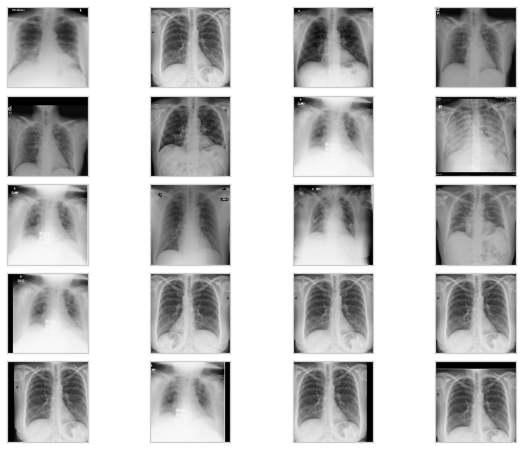

In [6]:
# Plot the results
fig, axes = plt.subplots(5, 4, figsize=(10, 8),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i, ax in enumerate(axes.flat):
    ax.imshow(train_images[i], cmap='binary_r')

### Tiny images with 16 * 16
We first start training the KNN model from a tiny images to compare the performance of different k and evaluate the optimal k value.

In [13]:
def preprocess_image(image_path, output_path, pre_path='preprocessed_training'):
    # Open the image using PIL
    image = Image.open(image_path).convert('L')

    # Crop the image to a square
    width, height = image.size
    size = min(width, height)
    left = (width - size) / 2
    top = (height - size) / 2
    right = (width + size) / 2
    bottom = (height + size) / 2
    cropped_image = image.crop((left, top, right, bottom))

    # Resize the image to 16x16 pixels
    resized_image = cropped_image.resize((16, 16))

    # Build the save path
    category_folder = os.path.basename(os.path.dirname(image_path))
    output_category_path = os.path.join(output_path, pre_path, category_folder)
    os.makedirs(output_category_path, exist_ok=True)

    # Define the output path
    output_image_path = os.path.join(output_category_path, os.path.basename(image_path))

    # Save the preprocessed image
    resized_image.save(output_image_path, 'JPEG')

In [14]:
# Traverse each folder in the training directory
training_folder = './data/Chext-X-ray-Images-Data-Set/train'
output_folder = './data/Chext-X-ray-Images-Data-Set'
for category_folder in os.listdir(training_folder):
    category_path = os.path.join(training_folder, category_folder)

    sub_output_path = os.path.join(output_folder, category_folder)
    # Traverse each image file in each folder
    for image_name in os.listdir(category_path):
        image_path = os.path.join(category_path, image_name)

        # Preprocess the image and save it
        preprocess_image(image_path, output_folder)

In [15]:
testing_folder = './data/Chext-X-ray-Images-Data-Set/test'
output_folder = './data/Chext-X-ray-Images-Data-Set'
for category_folder in os.listdir(testing_folder):
    category_path = os.path.join(testing_folder, category_folder)

    sub_output_path = os.path.join(output_folder, category_folder)
    # Traverse each image file in each folder
    for image_name in os.listdir(category_path):
        image_path = os.path.join(category_path, image_name)

        # Preprocess the image and save it
        preprocess_image(image_path, output_folder, 'preprocessed_testing')

In [16]:
def load_image(image_path):
    # Use PIL to load the image
    image = Image.open(image_path)
    # Flatten the image into a one-dimensional array
    image_data = np.array(image).flatten()
    return image_data

#### Take a fresh look at Tiny images (16*16)

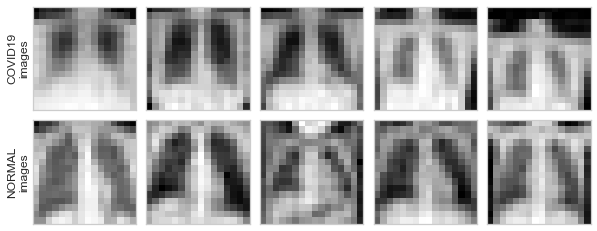

In [20]:
# Data folder paths
training_folder = output_folder + '/preprocessed_training'
testing_folder = output_folder + '/preprocessed_testing'

two_class_images = []
# Read training data
for class_folder in os.listdir(training_folder):
    class_path = os.path.join(training_folder, class_folder)
    class_images = []
    # Only show first 5 images
    for image_name in os.listdir(class_path)[:5]:
        image_path = os.path.join(class_path, image_name)
        image = Image.open(image_path)
        class_images.append(image)
    two_class_images.append(class_images)

# Plot the results
fig, ax = plt.subplots(2, 5, figsize=(10, 4),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i in range(5):
    ax[0, i].imshow(two_class_images[0][i], cmap='binary_r')
    ax[1, i].imshow(two_class_images[1][i], cmap='binary_r')

ax[0, 0].set_ylabel('COVID19\nimages')
ax[1, 0].set_ylabel('NORMAL\nimages');

In [23]:
X_train = []
y_train = []

# Read training data
for class_folder in os.listdir(training_folder):
    class_path = os.path.join(training_folder, class_folder)
    for image_name in os.listdir(class_path):
        image_path = os.path.join(class_path, image_name)
        # Convert image file to a vector
        image_data = load_image(image_path)
        X_train.append(image_data)
        y_train.append(class_folder)

X_train = np.array(X_train)
y_train = np.array(y_train)
# Convert categorical character labels to numerical labels, e.g., 'bedroom' -> 0
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
print("y_train_encoded:", y_train_encoded)

# Split the training data into training and validation sets in an 8:2 ratio
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train_encoded, test_size=0.2, random_state=42)

# Evaluate multiple K values for the K-NN classifier
k_list = list(range(2, 20))
best_k = None
best_accuracy = 0

val_accuracy_list = []
# Train models with different K values
for k in k_list:
    knn_classifier = KNeighborsClassifier(n_neighbors=k)

    knn_classifier.fit(X_train_split, y_train_split)

    # Calculate accuracy on the validation set
    y_val_pred = knn_classifier.predict(X_val_split)
    val_accuracy = accuracy_score(y_val_split, y_val_pred)
    val_accuracy_list.append(val_accuracy)

    # Observe different K values and their accuracies
    print(f"K={k}, Validation Accuracy: {val_accuracy}")

    # Update the best K value
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_k = k

print(f"Best K: {best_k} with Validation Accuracy: {best_accuracy}")

y_train_encoded: [0 0 0 ... 1 1 1]
K=2, Validation Accuracy: 0.9834710743801653
K=3, Validation Accuracy: 0.9752066115702479
K=4, Validation Accuracy: 0.977961432506887
K=5, Validation Accuracy: 0.977961432506887
K=6, Validation Accuracy: 0.9834710743801653
K=7, Validation Accuracy: 0.9807162534435262
K=8, Validation Accuracy: 0.9834710743801653
K=9, Validation Accuracy: 0.9752066115702479
K=10, Validation Accuracy: 0.9752066115702479
K=11, Validation Accuracy: 0.977961432506887
K=12, Validation Accuracy: 0.9807162534435262
K=13, Validation Accuracy: 0.9752066115702479
K=14, Validation Accuracy: 0.977961432506887
K=15, Validation Accuracy: 0.9752066115702479
K=16, Validation Accuracy: 0.977961432506887
K=17, Validation Accuracy: 0.9752066115702479
K=18, Validation Accuracy: 0.9752066115702479
K=19, Validation Accuracy: 0.9724517906336089
Best K: 2 with Validation Accuracy: 0.9834710743801653


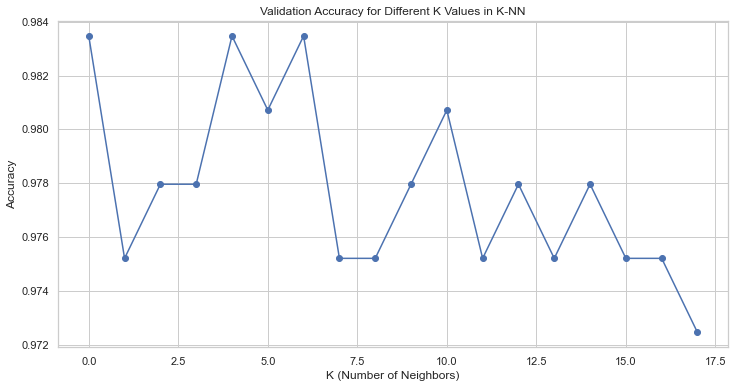

In [25]:
# Plotting the data
plt.figure(figsize=(12, 6))
plt.plot(val_accuracy_list, marker='o', linestyle='-')
plt.title('Validation Accuracy for Different K Values in K-NN')
plt.xlabel('K (Number of Neighbors)')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

### Different exploration
Do more exploration with larger images, using different features: raw sampled features, SIFT features, visual bag of words, using different machine learning methods, and comparing state-of-the-art deep learning methods

In [33]:
from sklearn.preprocessing import StandardScaler
import pickle
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Define the parameters
scaler = StandardScaler()
PATCH_SIZE = 8
STEP_SIZE = 4
N_clusters = 128  # The number of clusters (visual bag)


train_descriptors_dict = {}
# Extract patches from each image and compute SIFT features
if os.path.exists('train_descriptors.pkl'):
    with open('train_descriptors.pkl', 'rb') as file:
        train_descriptors_dict = pickle.load(file)

# Extract patches
def extract_patches(image, patch_size, step_size):
    patches = []
    h, w = image.shape[:2]
    for i in range(0, h - patch_size + 1, step_size):
        for j in range(0, w - patch_size + 1, step_size):
            patch = image[i:i + patch_size, j:j + patch_size]
            patches.append(patch)
    return patches

# Compute SIFT features for each patch
def compute_sift(patches):
    sift = cv2.SIFT_create()
    descriptors = []
    for patch in patches:
        kp = sift.detect(patch, None)
        kp, des = sift.compute(patch, kp)
        # Exclude empty descriptors
        if des is not None:
            descriptors.append(des[0])  # Only take the first keypoint

    if not descriptors:  # Check if descriptors list is empty
        # Add a default 128-dimensional random value
        default_descriptor = np.random.rand(128)
        descriptors.append(default_descriptor)

    descriptors = scaler.fit_transform(np.vstack(descriptors))
    return descriptors

# Train K-Means for the visual bag
def kmeans_for_bag(descriptors, N_clusters):
    kmeans = KMeans(n_clusters=N_clusters, random_state=0)
    kmeans.fit(descriptors)
    return kmeans

# Create a histogram for each training image
def create_histogram(image_name, visual_kmeans):
    descriptors = compute_descriptors(image_name)
    descriptors = descriptors.astype(float)
    labels = visual_kmeans.predict(descriptors)
    histogram, _ = np.histogram(labels, bins=N_clusters)
    return histogram

In [34]:
train_images = []
train_image_names = []
train_labels = []

class_folders = os.listdir(train_folder)
# Read all image data
for i, class_folder in enumerate(class_folders):
    class_path = os.path.join(train_folder, class_folder)
    for filename in os.listdir(class_path):
        image_path = os.path.join(class_path, filename)
        # All the images are grayscale, so you don't need to consider color.
        image = cv2.imread(image_path)
        image = cv2.resize(image, (150, 150))

        train_image_names.append(image_path)
        train_images.append(image)
        train_labels.append(i)

# If descriptors have been computed before, retrieve them
def compute_descriptors(image_name):
    if image_name in train_descriptors_dict:
        return train_descriptors_dict[image_name]
    else:
        image = cv2.imread(image_name)
        image = cv2.resize(image, (150, 150))

        patches = extract_patches(image, PATCH_SIZE, STEP_SIZE)
        return compute_sift(patches)

def train_visual_kmeans():
    train_descriptors = []
    for i, image_name in enumerate(train_image_names):
        print("compute sift feature for image:", i)
        descriptors = compute_descriptors(image_name)
        train_descriptors_dict[image_name] = descriptors
        train_descriptors.extend(descriptors)
    if not os.path.exists('train_descriptors.pkl'):
        # Save the feature dictionary
        with open('train_descriptors.pkl', 'wb') as file:
            pickle.dump(train_descriptors_dict, file)
    print("train_descriptors length:", len(train_descriptors))
    # Create the visual_words from the training descriptors
    visual_kmeans = kmeans_for_bag(train_descriptors, N_clusters)
    return visual_kmeans

# Compute histograms for each image if not already done
if os.path.exists("train_features.npy"):
    train_features = np.load('train_features.npy')
else:
    visual_kmeans = train_visual_kmeans()
    print("visual_kmeans completed")

    train_features = []
    for image_name in train_image_names:
        histogram = create_histogram(image_name, visual_kmeans)
        train_features.append(histogram)

    train_features = np.asarray(train_features)
    np.save('train_features.npy', train_features)

# Standardize and normalize each patch (SIFT feature)
# train_features = scaler.fit_transform(train_features)
print("train_features.shape:", train_features.shape)

# Function to train a Random Forest classifier
def trainRandomForestClassifier(X_train, X_val, y_train, y_val, feature_engine):
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_val)

    accuracy = accuracy_score(y_val, y_pred)
    print(f"Random Forest Accuracy of SIFT with {feature_engine}: {accuracy}")

# Function to train a Logistic Regression classifier
def trainLRClassifier(X_train, X_val, y_train, y_val, feature_engine):
    logistic_model = LogisticRegression(random_state=42)
    logistic_model.fit(X_train, y_train)

    # Predict
    y_pred_logistic = logistic_model.predict(X_val)

    accuracy_logistic = accuracy_score(y_val, y_pred_logistic)
    print(f"Logistic Regression Accuracy of SIFT with {feature_engine}: {accuracy_logistic}")

# Function to train a Support Vector Machine (SVM) classifier
def trainSVMClassifier(X_train, X_val, y_train, y_val, feature_engine):
    svm_model = SVC(kernel='rbf', random_state=42)
    svm_model.fit(X_train, y_train)

    # Make predictions
    y_pred_svm = svm_model.predict(X_val)

    # Evaluate the model
    accuracy_svm = accuracy_score(y_val, y_pred_svm)
    print(f"SVM Accuracy of SIFT with {feature_engine}: {accuracy_svm}")
    return svm_model


compute sift feature for image: 0
compute sift feature for image: 1
compute sift feature for image: 2
compute sift feature for image: 3
compute sift feature for image: 4
compute sift feature for image: 5
compute sift feature for image: 6
compute sift feature for image: 7
compute sift feature for image: 8
compute sift feature for image: 9
compute sift feature for image: 10
compute sift feature for image: 11
compute sift feature for image: 12
compute sift feature for image: 13
compute sift feature for image: 14
compute sift feature for image: 15
compute sift feature for image: 16
compute sift feature for image: 17
compute sift feature for image: 18
compute sift feature for image: 19
compute sift feature for image: 20
compute sift feature for image: 21
compute sift feature for image: 22
compute sift feature for image: 23
compute sift feature for image: 24
compute sift feature for image: 25
compute sift feature for image: 26
compute sift feature for image: 27
compute sift feature for image

C:\anoconda\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


visual_kmeans completed
train_features.shape: (1811, 128)


In [35]:
# Split the data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(train_features, train_labels, test_size=0.2, random_state=42)
trainRandomForestClassifier(X_train, X_val, y_train, y_val, feature_engine='kmeans')
trainLRClassifier(X_train, X_val, y_train, y_val, feature_engine='kmeans')
trainSVMClassifier(X_train, X_val, y_train, y_val, feature_engine='kmeans')

Random Forest Accuracy of SIFT with kmeans: 0.8787878787878788
Logistic Regression Accuracy of SIFT with kmeans: 0.8760330578512396
SVM Accuracy of SIFT with kmeans: 0.8898071625344353


SVC(random_state=42)

In [37]:
######## SIFT with simple flatten
train_features_simple_flatten = []
train_features_with_origin = []
for i, image_name in enumerate(train_image_names):
    descriptors = compute_descriptors(image_name)
    # Flatten (convert to 1D-vector)
    flattened_arr = descriptors.flatten()

    # Truncate or pad to 40,000 dimensions
    desired_length = 40000
    result_vector = np.zeros(desired_length)
    result_vector[:len(flattened_arr)] = flattened_arr[:desired_length]

    train_features_simple_flatten.append(result_vector)
    #### Use the most original method by directly reading image features with OpenCV
    img_ori_features = cv2.imread(image_name)
    # Resize all images to 256x256
    img_ori_features = cv2.resize(img_ori_features, (150, 150))
    train_features_with_origin.append(img_ori_features.flatten())

train_features_simple_flatten = np.asarray(train_features_simple_flatten)
print("train_features_simple_flatten.shape:", train_features_simple_flatten.shape)

######## SIFT with simple flatten
# Split the data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(train_features_simple_flatten, train_labels, test_size=0.2, random_state=42)
trainRandomForestClassifier(X_train, X_val, y_train, y_val, feature_engine='simple flatten')
trainLRClassifier(X_train, X_val, y_train, y_val, feature_engine='simple flatten')
trainSVMClassifier(X_train, X_val, y_train, y_val, feature_engine='simple flatten')

train_features_simple_flatten.shape: (1811, 40000)
Random Forest Accuracy of SIFT with simple flatten: 0.9035812672176309
Logistic Regression Accuracy of SIFT with simple flatten: 0.8099173553719008
SVM Accuracy of SIFT with simple flatten: 0.9035812672176309


SVC(random_state=42)

In [38]:
######## Original features as the train features
X_ori_features = np.array(train_features_with_origin)
print("X_ori_features.shape:", X_ori_features.shape)
X_train, X_val, y_train, y_val = train_test_split(X_ori_features, train_labels, test_size=0.2, random_state=42)
trainRandomForestClassifier(X_train, X_val, y_train, y_val, feature_engine='Original features')
trainLRClassifier(X_train, X_val, y_train, y_val, feature_engine='Original features')
svm_model = trainSVMClassifier(X_train, X_val, y_train, y_val, feature_engine='Original features')

X_ori_features.shape: (1811, 67500)
Random Forest Accuracy of SIFT with Original features: 0.9724517906336089


C:\anoconda\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy of SIFT with Original features: 0.9669421487603306
SVM Accuracy of SIFT with Original features: 0.9807162534435262


### Convolutional Neural Networks
Now using state-of-the-art deep learning methods: (Convolutional Neural Networks, CNNs)

In [39]:
import torch
from torch import nn, optim
from torchvision import transforms
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset

# Class labels
classes = os.listdir(train_folder)
class_labels = {idx: cls for idx, cls in enumerate(classes)}
reverse_class_labels = {cls: idx for idx, cls in enumerate(classes)}

class ImageDataset(Dataset):
    def __init__(self, train_folder, transform=None):
        self.train_folder = train_folder
        self.transform = transform
        self.image_paths = self.get_image_paths()
        self.labels = [reverse_class_labels[path.split('\\')[-2]] for path in self.image_paths]
        # print("self.labels:", self.labels)

    def get_image_paths(self):
        image_paths = []
        for root, _, files in os.walk(self.train_folder):
            for file in files:
                if file.endswith('.jpg'):
                    image_paths.append(os.path.join(root, file))
        return image_paths

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

### Model definition

In [48]:
# define cnn model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(10368, 64)
        self.fc2 = nn.Linear(64, 2)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = self.pool(nn.functional.relu(self.conv3(x)))

        x = x.view(-1, 32 * 18 * 18)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

#### Training a CNN2d model

In [49]:
# image size
img_size = (150, 150)
batch_size = 32

data_transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
])

# load Dataset
dataset = ImageDataset(train_folder, transform=data_transform)

# split train and val
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

model = CNNModel()

model

CNNModel(
  (conv1): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=10368, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
)

In [50]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 12
train_losses = []
test_losses = []
accuracy_list = []

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for images, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{epochs}'):
        optimizer.zero_grad()
        # print(f"{images.shape=}")
        outputs = model(images)
        # print(f"{outputs.shape=}, {labels.shape=}")
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    train_losses.append(train_loss/len(train_loader))
    test_losses.append(test_loss/len(val_loader))
    accuracy = correct / total * 100
    accuracy_list.append(accuracy)

    print(f'Epoch [{epoch+1}/{epochs}], '
          f'Training loss: {train_loss/len(train_loader):.4f}, '
          f'Validation loss: {test_loss/len(val_loader):.4f}, '
          f'Accuracy: {accuracy:.4f}%')

Epoch 1/12: 100%|██████████| 45/45 [01:31<00:00,  2.03s/it]


Epoch [1/12], Training loss: 0.3808, Validation loss: 0.2157, Accuracy: 93.8375%


Epoch 2/12: 100%|██████████| 45/45 [01:30<00:00,  2.02s/it]


Epoch [2/12], Training loss: 0.1078, Validation loss: 0.1093, Accuracy: 96.0784%


Epoch 3/12: 100%|██████████| 45/45 [01:33<00:00,  2.07s/it]


Epoch [3/12], Training loss: 0.0837, Validation loss: 0.0696, Accuracy: 97.4790%


Epoch 4/12: 100%|██████████| 45/45 [01:33<00:00,  2.07s/it]


Epoch [4/12], Training loss: 0.0637, Validation loss: 0.0630, Accuracy: 97.1989%


Epoch 5/12: 100%|██████████| 45/45 [01:30<00:00,  2.01s/it]


Epoch [5/12], Training loss: 0.0704, Validation loss: 0.0891, Accuracy: 96.0784%


Epoch 6/12: 100%|██████████| 45/45 [01:29<00:00,  1.99s/it]


Epoch [6/12], Training loss: 0.0572, Validation loss: 0.0504, Accuracy: 98.3193%


Epoch 7/12: 100%|██████████| 45/45 [01:34<00:00,  2.10s/it]


Epoch [7/12], Training loss: 0.0401, Validation loss: 0.0461, Accuracy: 98.0392%


Epoch 8/12: 100%|██████████| 45/45 [01:33<00:00,  2.08s/it]


Epoch [8/12], Training loss: 0.0294, Validation loss: 0.0475, Accuracy: 98.0392%


Epoch 9/12: 100%|██████████| 45/45 [01:26<00:00,  1.93s/it]


Epoch [9/12], Training loss: 0.0234, Validation loss: 0.0535, Accuracy: 97.7591%


Epoch 10/12: 100%|██████████| 45/45 [01:28<00:00,  1.96s/it]


Epoch [10/12], Training loss: 0.0198, Validation loss: 0.0597, Accuracy: 97.4790%


Epoch 11/12: 100%|██████████| 45/45 [01:28<00:00,  1.96s/it]


Epoch [11/12], Training loss: 0.0352, Validation loss: 0.0503, Accuracy: 98.3193%


Epoch 12/12: 100%|██████████| 45/45 [01:26<00:00,  1.93s/it]


Epoch [12/12], Training loss: 0.0213, Validation loss: 0.0613, Accuracy: 97.4790%


### PERFORMING EVALUATION

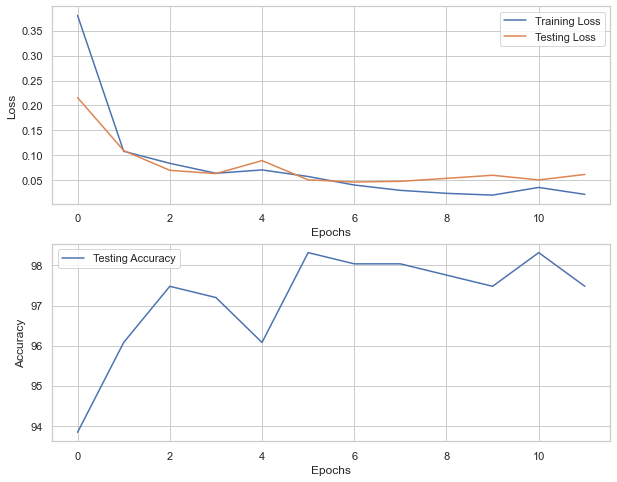

In [53]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

ax1.plot(train_losses, label='Training Loss')
ax1.plot(test_losses, label='Testing Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# draw curve
ax2.plot(accuracy_list, label='Testing Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.show()